<a href="https://colab.research.google.com/github/ASEM000/Physics-informed-neural-network-in-JAX/blob/main/%5B3%5D_PDE_Laplace_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Credits : Mahmoud Asem @Asem000  Septemeber 2021

In [1]:
#Imports
import jax 
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax

#### Laplace
$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$ 

<br>
$\text{p = 0 at x=0}$ <br>
$\text{p = y at x=2}$ <br>
$\frac{\partial p}{\partial y} = 0 \ at \ y=0,1$



In [2]:
N_b = 100
N_r = 10_000

ymin,ymax=0. ,1.
xmin,xmax = 0.,2.

'''boundary conditions'''

bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)



# P[0,y] = 0
y_b1 = jax.random.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b1 = jnp.zeros_like(y_b1)
bc_1 = jnp.zeros_like(y_b1)
BC_1 = jnp.concatenate([x_b1,y_b1,bc_1],axis=1)

# P[2,y] = y
y_b2 = jax.random.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b2 = jnp.ones_like(y_b2) *2
bc_2 = y_b2
BC_2 = jnp.concatenate([x_b2,y_b2,bc_2],axis=1)

# P_y[x,0] = 0
x_b3 = jax.random.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b3 = jnp.zeros_like(x_b3)
bc_3 = jnp.zeros_like(x_b3)
BC_3 = jnp.concatenate([x_b3,y_b3,bc_3],axis=1)

# P_y[x,1] = 0
x_b4 = jax.random.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b4 = jnp.ones_like(x_b4)
bc_4 = jnp.zeros_like(x_b4)
BC_4 = jnp.concatenate([x_b4,y_b4,bc_4],axis=1)

conds = [BC_1,BC_2,BC_3,BC_4]

#collocation points
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
colloc = jnp.concatenate([x_c,y_c],axis=1) 

def PDE_loss(x,y,u):
  u_x=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),0)(x,y)
  u_xx=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_x(x,y)),0)(x,y)

  u_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),1)(x,y)
  u_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_y(x,y)),1)(x,y)

  return u_xx(x,y) + u_yy(x,y)

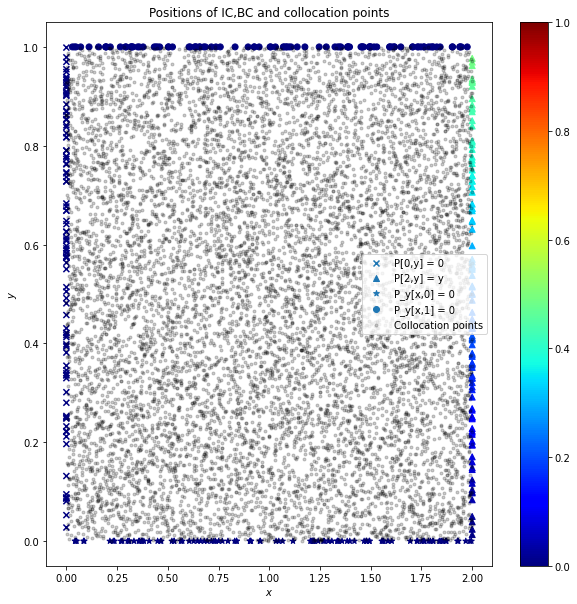

In [3]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_b1, y_b1, c=bc_1, marker='x', vmin=0, vmax=2,label='P[0,y] = 0',cmap=cm.jet)
plt.scatter(x_b2, y_b2, c=bc_2, marker='^', vmin=0, vmax=2,label='P[2,y] = y',cmap=cm.jet)
plt.scatter(x_b3, y_b3, c=bc_3, marker='*', vmin=0, vmax=2,label='P_y[x,0] = 0',cmap=cm.jet)
plt.scatter(x_b4, y_b4, c=bc_4, marker='o', vmin=0, vmax=2,label='P_y[x,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of IC,BC and collocation points');
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')

In [4]:
def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,conds):
  x_c,y_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda x,y : fwd(params,x,y)
  ufunc_y = lambda x,y:jax.grad(lambda x,y:jnp.sum(ufunc(x,y)),1)(x,y)
  
  loss =jnp.mean(PDE_loss(x_c,y_c,ufunc) **2)

  for cond in conds[0:2] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
    loss += MSE(ufunc(x_b,y_b),u_b)
  
  for cond in conds[2:4] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]  
    loss += MSE(ufunc_y(x_b,y_b),u_b)

  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)
  
  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params


In [6]:
# construct the MLP of  6 hidden layers of 20 neurons for each layer
params = init_params([2]+[8]*4+[1])

In [7]:
lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

In [37]:
%%time
epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(100) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=2.511e-03
Epoch=100	loss=1.859e-03
Epoch=200	loss=2.068e-03
Epoch=300	loss=3.023e-03
Epoch=400	loss=1.555e-03
Epoch=500	loss=2.305e-03
Epoch=600	loss=1.542e-03
Epoch=700	loss=1.507e-03
Epoch=800	loss=2.996e-03
Epoch=900	loss=1.554e-03
Epoch=1000	loss=1.413e-03
Epoch=1100	loss=1.633e-03
Epoch=1200	loss=1.529e-03
Epoch=1300	loss=1.517e-03
Epoch=1400	loss=1.148e-03
Epoch=1500	loss=1.670e-03
Epoch=1600	loss=1.590e-03
Epoch=1700	loss=1.268e-03
Epoch=1800	loss=1.060e-03
Epoch=1900	loss=1.056e-03
Epoch=2000	loss=1.709e-03
Epoch=2100	loss=1.865e-03
Epoch=2200	loss=1.051e-03
Epoch=2300	loss=1.035e-03
Epoch=2400	loss=1.108e-03
Epoch=2500	loss=1.161e-03
Epoch=2600	loss=1.181e-03
Epoch=2700	loss=1.052e-03
Epoch=2800	loss=1.314e-03
Epoch=2900	loss=1.332e-03
Epoch=3000	loss=1.073e-03
Epoch=3100	loss=1.316e-03
Epoch=3200	loss=1.134e-03
Epoch=3300	loss=9.556e-04
Epoch=3400	loss=9.471e-04
Epoch=3500	loss=1.054e-03
Epoch=3600	loss=1.149e-03
Epoch=3700	loss=1.091e-03
Epoch=3800	loss=1.885e-0

### Numerical solution

In [38]:
%%time 

from matplotlib import cm 
import matplotlib.pyplot as plt
import numpy as np
import numba
##variable declarations
nx = 101
ny = 101
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

##initial conditions
p = np.zeros((ny, nx))  # create a XxY vector of 0's

##plotting aids
x = np.linspace(0, 2, nx)
y = np.linspace(0, 1, ny)

##boundary conditions
p[:, 0] = 0  # p = 0 @ x = 0
p[:, -1] = y  # p = y @ x = 2
p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1

@numba.jit
def laplace_step(p, y, dx, dy):
    pn = p.copy()
    p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) / (2 * (dx**2 + dy**2)))
    
    #Boundary condition
    p[:, 0] = 0                 # p[y,0] = 0                   p = 0 @ x = 0
    p[:, -1] = y                # p[y,2] = y                   p = y @ x = 2
    p[0, :] = p[1, :]           # p_y[0,x] = 0                 dp/dy = 0 @ y = 0
    p[-1, :] = p[-2, :]         # p_y[1,x] = 0                 dp/dy = 0 @ y = 1

    norm = (np.sum(np.abs(p[:]) -np.abs(pn[:])) /np.sum(np.abs(pn[:])))
     
    return p,norm

norm = 1
step = 0
while norm> 1e-4:
  p,norm = laplace_step(p,y,dx,dy)
  step+=1
  if step %100 == 0:
    print(f'step={step}\tl1norm={norm:.3e}')

step=100	l1norm=4.592e-03
step=200	l1norm=2.352e-03
step=300	l1norm=1.586e-03
step=400	l1norm=1.197e-03
step=500	l1norm=9.619e-04
step=600	l1norm=8.042e-04
step=700	l1norm=6.911e-04
step=800	l1norm=6.060e-04
step=900	l1norm=5.396e-04
step=1000	l1norm=4.863e-04
step=1100	l1norm=4.426e-04
step=1200	l1norm=4.061e-04
step=1300	l1norm=3.751e-04
step=1400	l1norm=3.484e-04
step=1500	l1norm=3.251e-04
step=1600	l1norm=3.046e-04
step=1700	l1norm=2.864e-04
step=1800	l1norm=2.701e-04
step=1900	l1norm=2.554e-04
step=2000	l1norm=2.421e-04
step=2100	l1norm=2.299e-04
step=2200	l1norm=2.187e-04
step=2300	l1norm=2.084e-04
step=2400	l1norm=1.988e-04
step=2500	l1norm=1.900e-04
step=2600	l1norm=1.817e-04
step=2700	l1norm=1.740e-04
step=2800	l1norm=1.667e-04
step=2900	l1norm=1.599e-04
step=3000	l1norm=1.535e-04
step=3100	l1norm=1.474e-04
step=3200	l1norm=1.417e-04
step=3300	l1norm=1.363e-04
step=3400	l1norm=1.312e-04
step=3500	l1norm=1.263e-04
step=3600	l1norm=1.217e-04
step=3700	l1norm=1.173e-04
step=3800	

In [39]:
def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

In [40]:
N=100
X,Y = np.meshgrid(x, y)
pred = (fwd(params,X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1))).reshape(N+1,N+1)

### Numerical solution

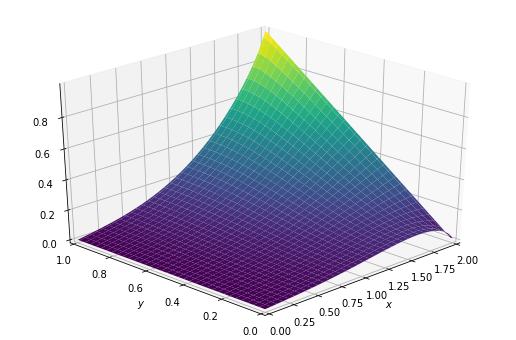

In [41]:
#numerical 
plot2D(X,Y,p)

### PINN solution

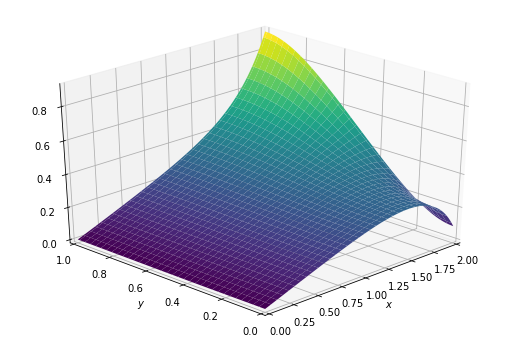

In [42]:
#prediction
plot2D(X,Y,pred)